In [106]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile



In [107]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [5]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "1b7y5mzz"


In [6]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
sweep_runs = sweep.runs

In [7]:
summary_list, config_list, name_list, sigmas = [], [], [], []
filename = f"moebius_linear_map_sweep_data_{SWEEP_ID}.csv"
if not isfile(filename):
    for run in sweep_runs:


        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)



        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})

        sigmas.append(run.history(keys=[f'Metrics/val/latent_statistics.latent_variance_{i}' for i in range(config_list[-1]['latent_dim'])]).iloc[-1].to_numpy()[1:])


        # .name is the human-readable name of the run.
        name_list.append(run.name)



    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "sigmas" : sigmas
        })

    runs_df.to_csv(filename)
else:
    runs_df = pd.read_csv(filename)

In [14]:
runs_df.loc[0]['summary']['mixing_linear_map_cima']

0

In [9]:
len(runs_df)

59

In [16]:
data = [ (summary['Metrics/val/mcc'], summary['Metrics/val/cima'], config['latent_dim'], config['decoder_var'], config['model.prior'], sigma, summary['mixing_linear_map_cima']) for summary, config, sigma in zip(runs_df['summary'], runs_df['config'], runs_df['sigmas'])]

$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [ ]:
len(data)

In [17]:
gamma_sq = [np.array(1./d[3]) for d in data]
prior = [d[4] for d in data]
sigmas = runs_df.sigmas.to_numpy()
mcc = np.array([d[0] for d in data])
cima = np.array([d[1] for d in data])
dim = np.array([d[2] for d in data])
mixing_cima = np.array([d[6] for d in data])

In [18]:
ext_gamma_sq = [g*np.ones((d, 1)) for g,d in zip(gamma_sq, dim)]

In [75]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False, positions=None):

    if positions is None:
        positions = xticks
    fig, ax = plt.subplots()#plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(positions)
    # plt.tight_layout()
    plt.savefig(filename)

In [76]:
def cima_mcc(cimas, mccs, mixing_cimas, priors,  prior_name):
    cima = np.array([c for c,p in zip(cimas, priors) if p == prior_name])
    mcc = np.array([m for m,p in zip(mccs, priors) if p == prior_name])
    mixing_cima = np.array([d for d,p in zip(mixing_cimas, priors) if p == prior_name])


    cima_vs_mixing_cima = [ np.array([c for mc, c in zip(mixing_cima, cima) if mc==cima_select]) for cima_select in np.unique(mixing_cimas)  ]
    mcc_vs_mixing_cima = [ np.array([m for mc, m in zip(mixing_cima, mcc) if mc==cima_select]) for cima_select in np.unique(mixing_cimas)  ]

    return cima, mcc, mixing_cima, cima_vs_mixing_cima, mcc_vs_mixing_cima

In [77]:
cima_gauss, mcc_gauss, mixing_cima_gauss, cima_vs_mixing_cima_gauss, mcc_vs_mixing_cima_gauss = cima_mcc(cima, mcc, mixing_cima, prior, "gaussian")
cima_laplace, mcc_laplace, mixing_cima_laplace, cima_vs_mixing_cima_laplace, mcc_vs_mixing_cima_laplace = cima_mcc(cima, mcc, mixing_cima, prior, "laplace")
cima_uniform, mcc_uniform, mixing_cima_uniform, cima_vs_mixing_cima_uniform, mcc_vs_mixing_cima_uniform = cima_mcc(cima, mcc, mixing_cima, prior, "uniform")

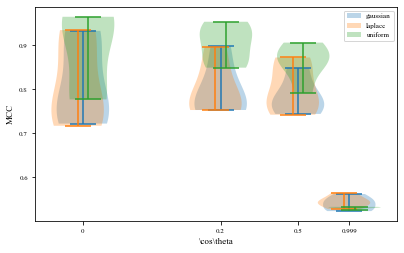

In [108]:
violin_by_prior(mcc_vs_mixing_cima_gauss, mcc_vs_mixing_cima_laplace, mcc_vs_mixing_cima_uniform,np.log10(np.unique(mixing_cima)+1e-3), r'\cos\theta', 'MCC',  0.05, 'mcc_vs_mixing_cima', positions=[0,.2,.5,.999])